**Goal:** Lets build a basic conjoint analysis tool in Python using FastAI (using a basic linear regression model) and the StreamLit library for the UI.

Inspiration: https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework

Import the basic libraries here.

In [1]:
import pandas as pd

For now lets play with existing data. Later can replace this with a survey designer and a survey administrator module.

Lets import some basic data.

In [25]:
training_data = pd.read_csv("pizza_data.csv")
training_data.head()

,brand,price,weight,crust,cheese,size,toppings,spicy,ranking
0,Dominos,$1.00,100g,thin,Mozzarella,regular,paneer,normal,11
1,Pizza hut,$3.00,100g,thin,Cheddar,large,mushroom,normal,12
2,Onesta,$4.00,200g,thin,Mozzarella,regular,mushroom,normal,9
3,Pizza hut,$4.00,400g,thick,Cheddar,regular,paneer,normal,2
4,Pizza hut,$2.00,300g,thin,Mozzarella,regular,mushroom,extra,8


Lets check the data for any incomplete or missing values

In [12]:
training_data.isna().sum()

brand       0
price       0
weight      0
crust       0
cheese      0
size        0
toppings    0
spicy       0
ranking     0
dtype: int64

Lets look for the most common values

In [14]:
modes = training_data.mode().iloc[0]
modes

brand        Dominos
price          $1.00
weight          100g
crust          thick
cheese       Cheddar
size           large
toppings    mushroom
spicy          extra
ranking            1
Name: 0, dtype: object

Lets get a quick summary of the data. Lets import numpy first.

In [60]:
import numpy as np

In [61]:
training_data.describe(include=([np.number,object]))
# Doesn't seem to work as well
# training_data.describe 

,brand,price,weight,crust,cheese,size,toppings,spicy,ranking
count,16,16,16,16,16,16,16,16,16.000000
unique,4,4,4,2,2,2,2,2,NaN
top,Dominos,$1.00,100g,thin,Mozzarella,regular,paneer,normal,NaN
freq,4,4,4,8,8,8,8,8,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.500000
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.760952
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.750000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.500000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.250000


Lets do some light feature engineering

In [55]:
added_columns = list(pd.get_dummies(training_data,columns = ['brand','crust', 'weight', 'cheese','size','toppings','spicy'], drop_first=False).columns)
# Took a while to figure out
added_columns = [x for x in added_columns if x not in list(training_data.columns)]
# You can also used set(list1) - set(list2) here
added_columns

['brand_Dominos',
 'brand_Onesta',
 'brand_Oven Story',
 'brand_Pizza hut',
 'crust_thick',
 'crust_thin',
 'weight_100g',
 'weight_200g',
 'weight_300g',
 'weight_400g',
 'cheese_Cheddar',
 'cheese_Mozzarella',
 'size_large',
 'size_regular',
 'toppings_mushroom',
 'toppings_paneer',
 'spicy_extra',
 'spicy_normal']

In [47]:
cj_data = pd.get_dummies(training_data,columns = ['brand','crust', 'weight', 'cheese','size','toppings','spicy'], drop_first=False)
cj_data.head()

,price,ranking,brand_Dominos,brand_Onesta,brand_Oven Story,brand_Pizza hut,crust_thick,crust_thin,weight_100g,weight_200g,weight_300g,weight_400g,cheese_Cheddar,cheese_Mozzarella,size_large,size_regular,toppings_mushroom,toppings_paneer,spicy_extra,spicy_normal
0,$1.00,11,True,False,False,False,False,True,True,False,False,False,False,True,False,True,False,True,False,True
1,$3.00,12,False,False,False,True,False,True,True,False,False,False,True,False,True,False,True,False,False,True
2,$4.00,9,False,True,False,False,False,True,False,True,False,False,False,True,False,True,True,False,False,True
3,$4.00,2,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,True,False,True
4,$2.00,8,False,False,False,True,False,True,False,False,True,False,False,True,False,True,True,False,True,False


Not lets deal with the price variable

In [31]:
cj_data['price_flt']=cj_data['price'].str.replace('$','').astype(float)
cj_data.head()

,price,ranking,brand_Dominos,brand_Onesta,brand_Oven Story,brand_Pizza hut,crust_thick,crust_thin,weight_100g,weight_200g,...,weight_400g,cheese_Cheddar,cheese_Mozzarella,size_large,size_regular,toppings_mushroom,toppings_paneer,spicy_extra,spicy_normal,price_flt
0,$1.00,11,True,False,False,False,False,True,True,False,...,False,False,True,False,True,False,True,False,True,1.0
1,$3.00,12,False,False,False,True,False,True,True,False,...,False,True,False,True,False,True,False,False,True,3.0
2,$4.00,9,False,True,False,False,False,True,False,True,...,False,False,True,False,True,True,False,False,True,4.0
3,$4.00,2,False,False,False,True,True,False,False,False,...,True,True,False,False,True,False,True,False,True,4.0
4,$2.00,8,False,False,False,True,False,True,False,False,...,False,False,True,False,True,True,False,True,False,2.0


Lets add this to our added column list. We'll need this later.

In [58]:
added_columns.append('price_flt')

<Axes: >

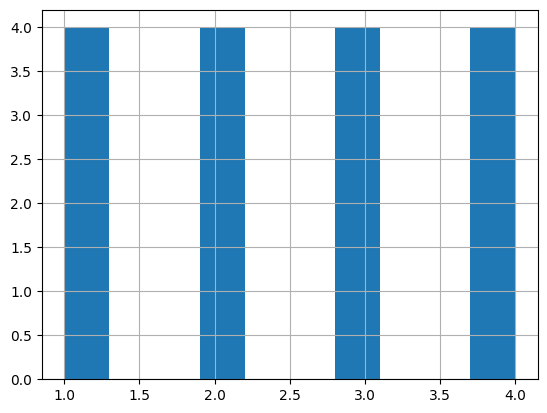

In [32]:
cj_data['price_flt'].hist()

Lets get a list of the added columns together

In [59]:
added_columns

['brand_Dominos',
 'brand_Onesta',
 'brand_Oven Story',
 'brand_Pizza hut',
 'crust_thick',
 'crust_thin',
 'weight_100g',
 'weight_200g',
 'weight_300g',
 'weight_400g',
 'cheese_Cheddar',
 'cheese_Mozzarella',
 'size_large',
 'size_regular',
 'toppings_mushroom',
 'toppings_paneer',
 'spicy_extra',
 'spicy_normal',
 'price_flt']